Рассмотрим сегментирование изображений с помощью глубоких нейросетевых архитектур на примере [Mask R-CNN](https://arxiv.org/abs/1703.06870) с использованием [torchvision](https://pytorch.org/vision/stable/index.html).

Импортируем требуемые библиотеки и загрузим предобученную модель.

In [1]:
import os
from os.path import exists, join, basename, splitext

import random
import PIL
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)
  
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model = model.eval().cpu()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 72.2MB/s]


Загрузим и считаем изображение

In [2]:
!gdown 14CSVdok0NTd9NRHKv2WXg34Z7Wykui8A
image_file = '/content/Comp_Vision_Task_5_File_2.jpg'

Downloading...
From: https://drive.google.com/uc?id=14CSVdok0NTd9NRHKv2WXg34Z7Wykui8A
To: /content/example_image.jpg
100% 164k/164k [00:00<00:00, 62.9MB/s]


Произведем сегментацию изображения при помощи модели

In [3]:
t = time.time()
image = PIL.Image.open(image_file)
image_tensor = torchvision.transforms.functional.to_tensor(image).cpu()
output = model([image_tensor])[0]
print('Время распознавания: %.3fs' % (time.time() - t))

Время распознавания: 11.228s


В качестве результата возвращается словарь со следующими ключами:

Результаты работы модели находятся в словаре:

*   boxes -- bounding boxes обнаруженных объектов (в виде <code>x1, y1, x2, y2</code> — отсчет начинается от левого верхнего края изображения)
*   labels -- метки назначенных классов
*   scores -- вероятности отнесения к назначенным классам
*   masks -- маски -- результат сегментации

Обратим внимание на то, что значения интенсивностей пикселей масок и координаты коробок (bounding boxes) не являются целыми числами. В дальнейшем, исправим это.






In [9]:
output.keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

Данная модель способна определить более 90 различных объектов. Соответствующий файл скачивается в формате .json, который нетрудно распарсить средствами питона. Но для данной темы достаточно определить эти типы объектов явным образом.

In [5]:
coco_names = ['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

Произведем небольшое преобразование, а именно -- отберем только те обнаруженные объекты, в которых модель относительно уверена (значение score больше 0.5), произведем бинаризацию значений масок и актуализируем значения bounding boxes.

In [6]:
result = {}
result['masks'] = []
result['labels'] = []
result['scores'] = []
result['boxes'] = []

for i in range(len(output['scores'])):
  if output['scores'][i] <= 0.5:
    continue
  # Исправляем маски
  one_mask = output['masks'][i][0].cpu().numpy()
  one_mask[one_mask >= np.max(one_mask) * 0.5] = 1
  one_mask[one_mask < np.max(one_mask) * 0.5] = 0
  result['masks'].append(one_mask)
  # Исправляем коробки
  result['boxes'].append(output['boxes'][i].int().cpu().numpy())
  # Добавляем остальное
  result['scores'].append(output['scores'][i].cpu().numpy())
  result['labels'].append(output['labels'][i].cpu().numpy())

Проиллюстрируем результат

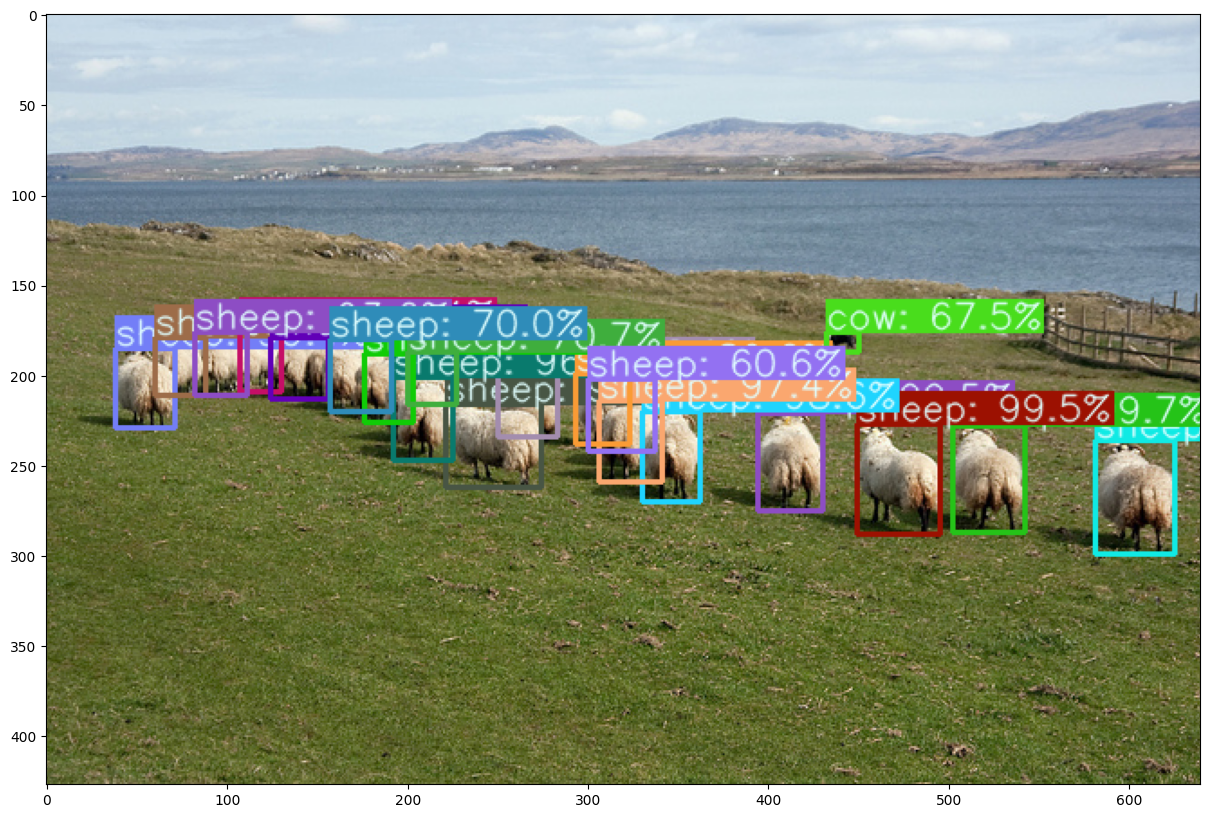

In [7]:
colors = [[random.randint(0, 255) for _ in range(3)] for _ in coco_names]

result_image = np.array(image.copy())
for box, label, score, mask in zip(result['boxes'], result['labels'], result['scores'], result['masks']):
  color = random.choice(colors)
  
  # draw box
  tl = round(0.002 * max(result_image.shape[0:2])) + 1  # line thickness
  c1, c2 = (box[0], box[1]), (box[2], box[3])
  cv2.rectangle(result_image, c1, c2, color, thickness=tl)
  # draw text
  display_txt = "%s: %.1f%%" % (coco_names[label], 100*score)
  tf = max(tl - 1, 1)  # font thickness
  t_size = cv2.getTextSize(display_txt, 0, fontScale=tl / 3, thickness=tf)[0]
  c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
  cv2.rectangle(result_image, c1, c2, color, -1)  # filled
  cv2.putText(result_image, display_txt, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
  
plt.figure(figsize=(15, 10))
plt.imshow(result_image)

Посмотрим на полученные маски

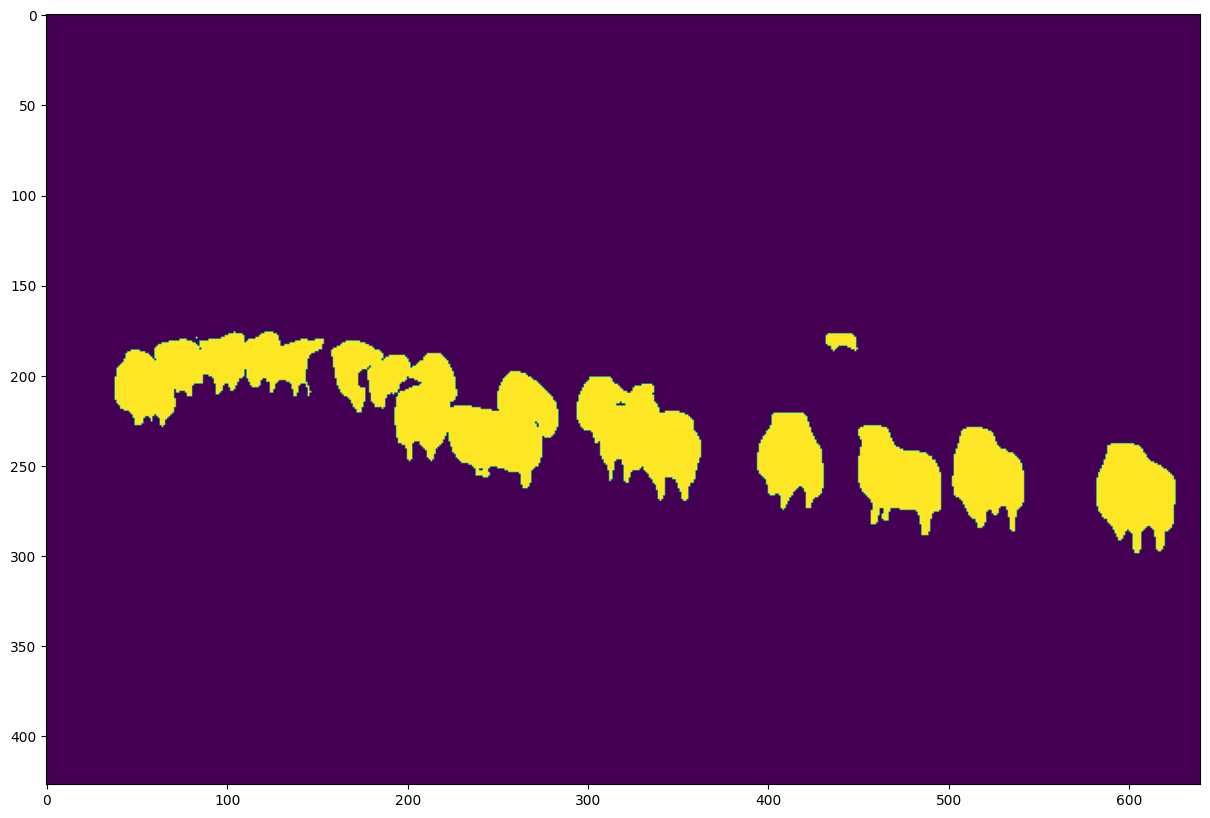

In [8]:
all_masks = np.sum(result['masks'],axis=0)
all_masks[all_masks > 1] = 1
plt.figure(figsize=(15, 10))
plt.imshow(all_masks)

Для определения объекта с наибольшей площадью сегментации по версии модели, необходимо проанализировать маски всех обнаруженных объектов. Выберем объект с маской, имеющей наибольшую площадь.

In [10]:
# Вычисление площадей масок
mask_areas = [np.sum(mask) for mask in result['masks']]

# Индекс объекта с наибольшей площадью
largest_area_index = np.argmax(mask_areas)

# Выбор площади и метки класса выбранного объекта
largest_area = mask_areas[largest_area_index]
selected_class = result['labels'][largest_area_index]
selected_score = result['scores'][largest_area_index]

# Преобразование индекса класса в название класса
selected_class_name = coco_names[selected_class]

print("Наибольшая площадь сегментации по версии модели:")
print("Класс:", selected_class_name)
print("Вероятность отнесения к классу:", selected_score)

Наибольшая площадь сегментации по версии модели:
Класс: sheep
Вероятность отнесения к классу: 0.99853337


Для вычисления доли площади выбранного объекта относительно площади всего изображения можно использовать следующий код:

In [11]:
image_area = result['masks'][0].shape[0] * result['masks'][0].shape[1]  # Площадь всего изображения
selected_object_area = np.sum(result['masks'][largest_area_index])  # Площадь выбранного объекта

area_ratio = selected_object_area / image_area  # Доля площади выбранного объекта относительно площади всего изображения

print("Доля площади выбранного объекта относительно площади всего изображения:", area_ratio)

Доля площади выбранного объекта относительно площади всего изображения: 0.0068574355971896955


In [12]:
selected_class_name = coco_names[selected_class]

print("Метка назначенного класса выбранного объекта:", selected_class_name)

Метка назначенного класса выбранного объекта: sheep


Для определения границ соответствующего прямоугольника выбранного объекта можно использовать следующий код:

In [13]:
x = result['boxes'][largest_area_index][0]  # Координата x левого верхнего угла
y = result['boxes'][largest_area_index][1]  # Координата y левого верхнего угла
width = result['boxes'][largest_area_index][2] - x  # Ширина прямоугольника
height = result['boxes'][largest_area_index][3] - y  # Высота прямоугольника

print("Координата x левого верхнего угла прямоугольника:", x)
print("Координата y левого верхнего угла прямоугольника:", y)
print("Ширина прямоугольника (в пикселях):", width)
print("Высота прямоугольника (в пикселях):", height)

Координата x левого верхнего угла прямоугольника: 581
Координата y левого верхнего угла прямоугольника: 236
Ширина прямоугольника (в пикселях): 44
Высота прямоугольника (в пикселях): 63
